# Data Challenge

### Problem Statement:

The CSV we have provided contains data extracted from videos of patients captured using the
Machine Medicine Technologies product KELVIN. The columns relate to body measurements, for
instance the “height” column is the height of the patient, the “face” column is the length of the face,
etc. The “var1”,…,”var4” columns are additional variables, it is not important to know what these
are.

### Tasks:

- List three things that one should consider in terms of pre-processing this specific data set.
- Guess what the unit of measurement of patient height in this dataset.
- Write a function that creates a plot of the distribution for a column of the data.
- Visually summarise the entire dataset in whichever way you think is most appropriate.
- Using this dataset, provide an estimate of the average patient height. Is it significantly greater
than 750?
- Characterise the distribution of the torso length (i.e. a sentence with numeric values).
- Using whichever statistical test you think appropriate, examine the difference between the
length of left arm and length of right arm.
- Compare the “left_shin” and “left_shin2” columns – what conclusion can you draw?
- Train a simple model to predict height using all other variables. Visualise the performance of this
model.
- Train a more complex model to predict height. Compare the performance of these two models.

# Data Exploration and Preparation

### Loading the data

- This section includes loading the data, understanding the basic description of the data; followed by cleanup & imputations as required.

In [545]:
# Importing the required packages

from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

In [546]:
# Loading the data and previewing the shape of the dataframe

patient_data = pd.read_csv('../df.csv')
print("The shape of the dataframe is {}".format(patient_data.shape))

The shape of the dataframe is (1475, 14)


In [547]:
patient_data.head()

,Unnamed: 0,height,face,torso,left_shin,left_shin2,right_shin,shoulder,left_arm,right_arm,var1,var2,var3,var4
0,2b8cfe,718.364242,70.590966,269.515232,141.239887,207.537653,132.184916,173.261397,131.966158,133.629282,3.521170,0.465162,2.604957,10
1,2b8d62,716.408785,70.291010,269.095971,140.472361,207.911571,131.975686,173.246057,131.834962,133.321101,3.695440,0.466050,2.651357,10
2,2b8dc6,714.962277,70.080707,268.745611,139.719235,208.382592,131.713437,173.365407,131.959255,133.123379,3.842206,0.461098,2.697869,10
3,2b8e2a,714.013129,69.785521,268.532332,138.903499,208.878420,131.519061,173.468325,132.536927,132.971018,3.931842,0.464465,2.597504,10
4,2b8e8e,713.687593,69.647635,268.520798,138.292113,209.162872,131.501779,173.625843,132.877215,132.917984,3.981150,0.459436,2.497521,10


### Variable Identification

In [548]:
print("Looking at individual features:\n")
# patient_data.dtypes
patient_data.info()

Looking at individual features:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1475 entries, 0 to 1474
Data columns (total 14 columns):
Unnamed: 0    1475 non-null object
height        1475 non-null float64
face          1425 non-null float64
torso         1475 non-null float64
left_shin     1475 non-null float64
left_shin2    1470 non-null float64
right_shin    1475 non-null float64
shoulder      1475 non-null float64
left_arm      1475 non-null float64
right_arm     1475 non-null float64
var1          1435 non-null float64
var2          1475 non-null float64
var3          1475 non-null float64
var4          1475 non-null int64
dtypes: float64(12), int64(1), object(1)
memory usage: 161.5+ KB


In [549]:
# Checking for unique values
patient_data.nunique()

Unnamed: 0    1475
height        1470
face          1176
torso         1470
left_shin     1466
left_shin2    1458
right_shin    1470
shoulder      1450
left_arm      1446
right_arm     1442
var1          1190
var2          1449
var3          1470
var4             5
dtype: int64

In [550]:
# dropping the unique column
patient_data = patient_data.iloc[:,1:]

In [551]:
# Checking for nan values
patient_data.isnull().sum()

height         0
face          50
torso          0
left_shin      0
left_shin2     5
right_shin     0
shoulder       0
left_arm       0
right_arm      0
var1          40
var2           0
var3           0
var4           0
dtype: int64

In [552]:
print("Number of duplicate records are:{}".format(patient_data.duplicated().sum()))

Number of duplicate records are:5


In [553]:
patient_data.describe().T

,count,mean,std,min,25%,50%,75%,max
height,1475.0,736.490845,176.959125,109.675758,620.395227,742.420174,845.007426,1439.150017
face,1425.0,49.743961,27.514774,3.084728,23.891749,50.517693,69.414903,121.884848
torso,1475.0,251.350123,87.017097,28.810246,183.835898,250.059006,305.894377,674.834122
left_shin,1475.0,166.085670,35.351708,29.425556,143.528854,170.019236,190.179903,254.593916
left_shin2,1470.0,211.104564,52.673392,66.954828,175.190643,209.447995,248.631672,403.353891
right_shin,1475.0,164.318308,36.662495,26.965597,141.515665,167.068308,189.716856,252.385258
shoulder,1475.0,158.388722,50.034481,1.913001,128.609104,153.533341,180.354901,482.735492
left_arm,1475.0,123.490944,46.060624,-1.000000,95.832277,122.203820,148.028597,412.144406
right_arm,1475.0,124.180951,43.940488,-1.000000,97.348004,123.985295,151.154657,256.857427
var1,1435.0,4.708036,3.709961,0.360236,2.584477,4.064704,5.614410,39.359172


#### Initial Observations:

- There are a total of 1475 records with 14 columns of which the unnamed column is clearly the unique id and var4 is a categorical type with 4 categories.
- There are no duplicate records.
- Only var3 has negative values.
- Columns face and var1 have small number of negative values which needs to be treated.

## List three things that one should consider in terms of pre-processing this specific data set.

- In order to pre-process this dataset following three things should be considered:
    - Missing value treatment.
    - Few of the columns are skewed which may require transformations to fix it.
    - The magnitudes of the variables are also different to each other which implies that we may need to scale the data before predictive modeling.
    - There are negative values in left_arm, right_arm and var3 which needs to be treated.

### Missing value treatment

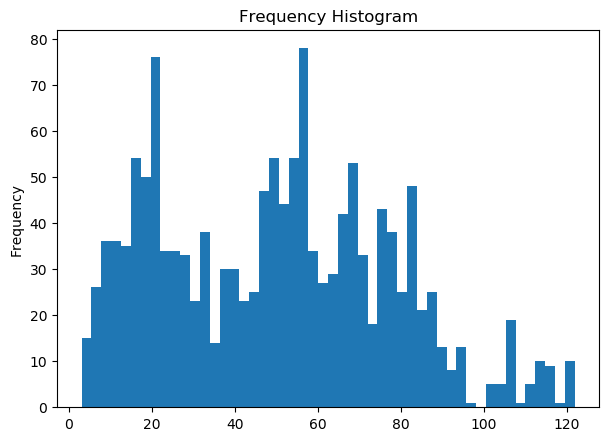

In [554]:
plot_distribution(patient_data['face'])
# sns.distplot(patient_data['face'], hist=True)

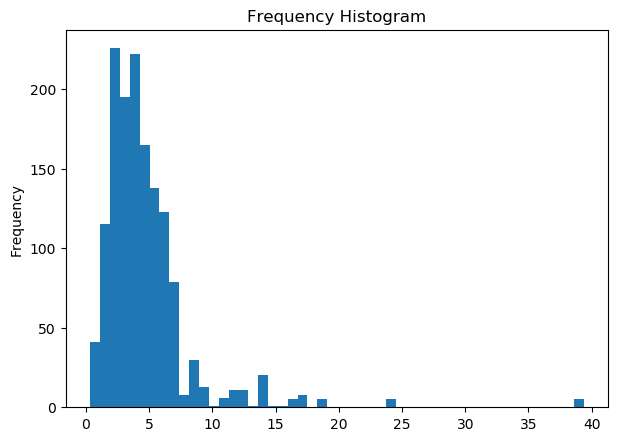

In [555]:
plot_distribution(patient_data['var1'])

In [556]:
# looking for negative values in the columns

negative_features =[]
negative_features.append([col for col in patient_data.columns.to_list()[1:] if len(patient_data[(patient_data[col]<0)]) != 0])
print("The features with negative values are:\n",negative_features)

The features with negative values are:
 [['left_arm', 'right_arm', 'var3']]


In [557]:
patient_data[patient_data['left_arm']<0]

,height,face,torso,left_shin,left_shin2,right_shin,shoulder,left_arm,right_arm,var1,var2,var3,var4
198,618.296152,NaN,219.272060,132.428492,176.377559,133.310642,132.471912,-1.0,109.496965,NaN,0.346495,1.028406,11
302,617.107549,52.461682,216.009138,124.715538,163.075436,139.510387,128.606062,-1.0,105.235004,4.334734,0.434464,0.171468,12
590,658.771896,55.267924,166.637639,169.072821,203.418194,171.113964,138.200975,-1.0,118.090349,3.926442,0.521411,3.330239,12
871,718.009489,8.232946,183.923275,159.263430,190.818820,143.851204,179.520746,-1.0,141.935562,6.047439,0.376913,3.992794,12
927,850.683379,55.264599,297.699272,183.641718,209.694647,188.939146,185.354600,-1.0,145.496407,2.493547,0.165249,-0.422838,10


In [558]:
patient_data[patient_data['right_arm']<0]

,height,face,torso,left_shin,left_shin2,right_shin,shoulder,left_arm,right_arm,var1,var2,var3,var4
510,279.672618,23.597152,94.051391,66.106444,91.504336,61.001102,57.685749,49.284171,-1.0,1.151929,0.432808,2.116985,11
652,645.476135,30.497614,233.639149,131.311896,139.449028,143.718859,150.836485,77.505774,-1.0,2.364220,0.302400,2.048539,10
696,881.051311,114.755212,340.514904,154.462583,152.010015,175.648732,221.489079,199.399506,-1.0,5.070410,0.513716,1.851538,12
929,850.968044,55.264599,298.116295,183.724365,209.998978,188.598476,185.498100,154.949386,-1.0,2.493547,0.157300,-0.423176,10
1185,900.757032,21.058700,441.519964,197.242992,253.249179,222.178871,154.205175,199.405984,-1.0,8.776878,0.316562,1.894811,13


In [559]:
# patient_data['left_arm'].replace(-1,np.nan, inplace=True)
# patient_data['right_arm'].replace(-1,np.nan, inplace=True)

In [560]:
patient_data['left_shin2'].fillna(patient_data['left_shin2'].mean(), inplace=True)
patient_data['face'].fillna(patient_data['face'].mean(), inplace=True)
patient_data['var1'].fillna(patient_data['var1'].mean(), inplace=True)

#### Guess what the unit of measurement of patient height in this dataset.

- The patient's height is in millimeter.
- As per my assumption, this data belongs to children.

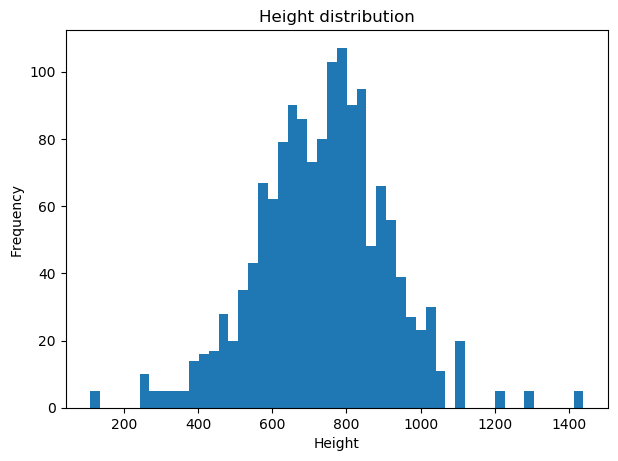

In [561]:
plot_distribution(patient_data['height'], title='Height distribution', xlabel='Height')

#### Write a function that creates a plot of the distribution for a column of the data.

In [562]:
def plot_distribution(col, bins=50, title='Frequency Histogram', xlabel=''):
    plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
    plt.hist(col, bins)
    plt.gca().set(title=title, xlabel=xlabel, ylabel='Frequency')

#### Visually summarise the entire dataset in whichever way you think is most appropriate.

<Figure size 3000x3000 with 0 Axes>

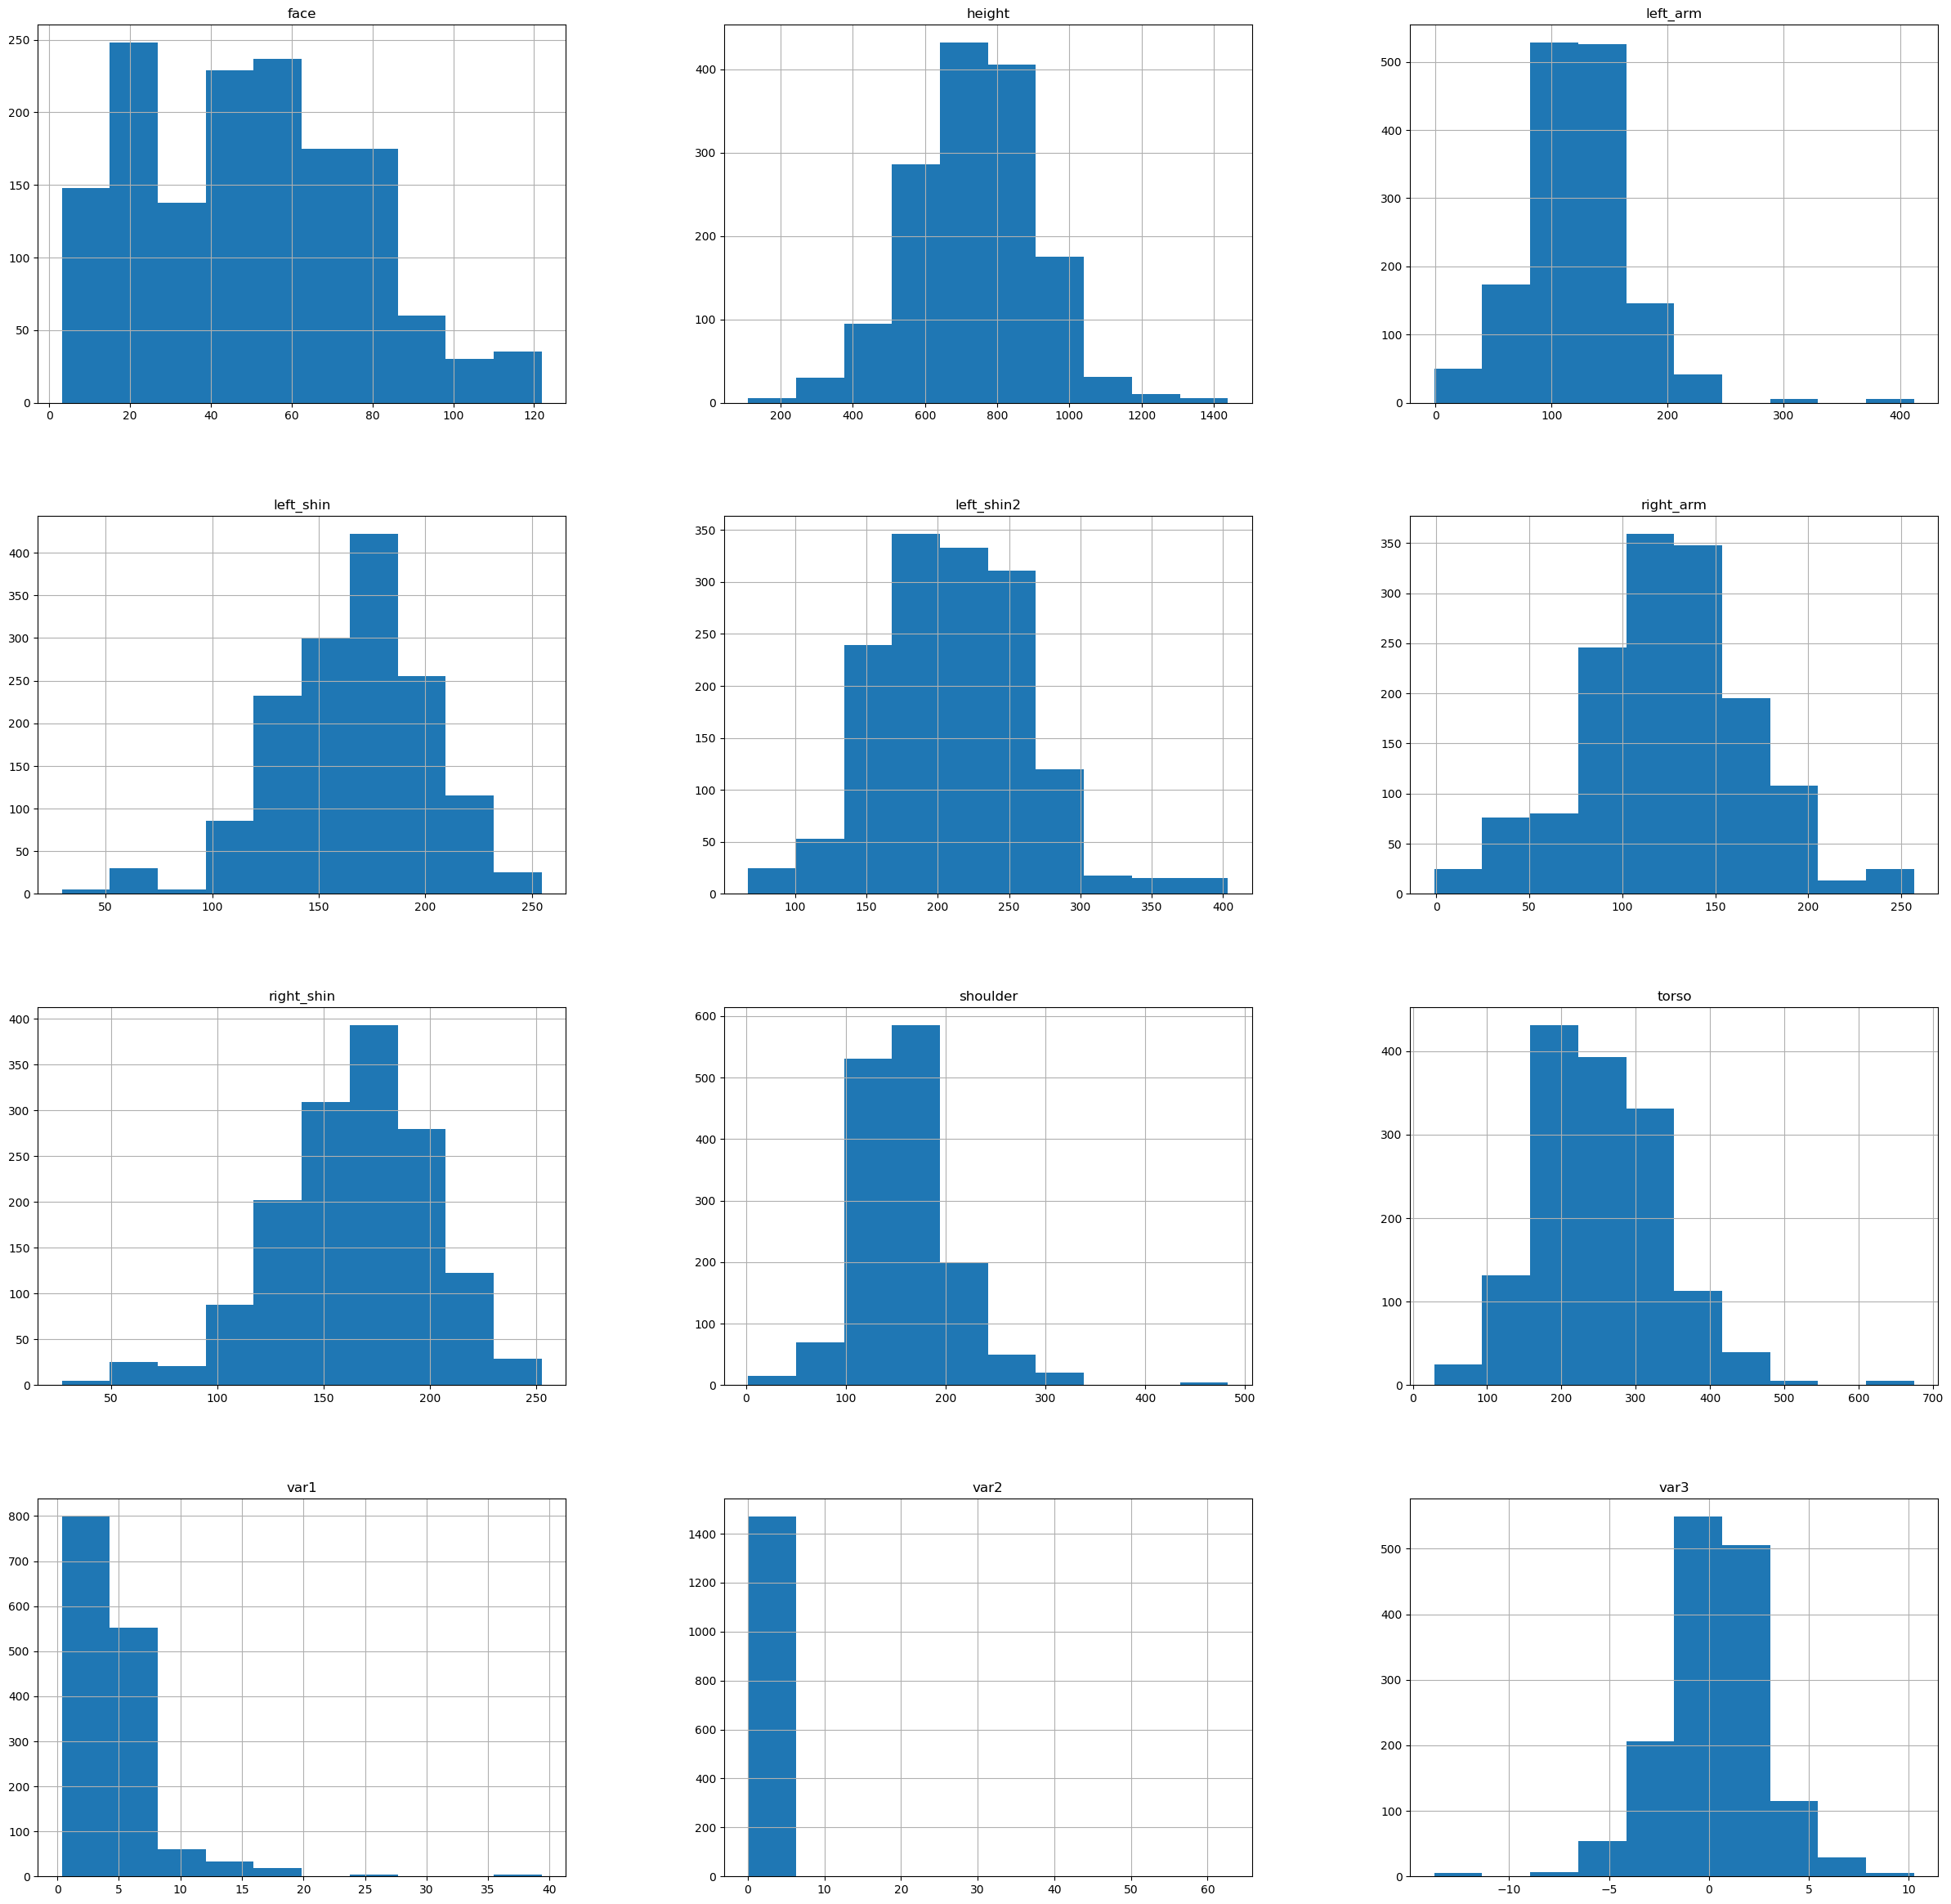

In [563]:
# sns.pairplot(patient_data)

plt.figure(figsize=(30,30))
patient_data.iloc[:,:12].hist(figsize=(30,30));

#### Using this dataset, provide an estimate of the average patient height. Is it significantly greater than 750?

#### Characterise the distribution of the torso length (i.e. a sentence with numeric values).

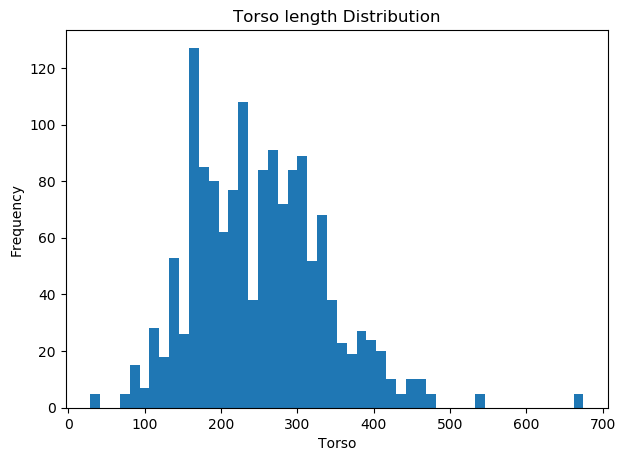

In [564]:
plot_distribution(patient_data['torso'], title='Torso length Distribution', xlabel='Torso')

In [565]:
skew_features=patient_data.skew().sort_values(ascending=False)
skewness=pd.DataFrame({'Skew':skew_features})
skewness

,Skew
var2,19.780681
var4,9.653347
var1,4.252654
shoulder,1.276921
left_arm,0.902430
torso,0.658916
left_shin2,0.378653
face,0.298383
right_arm,0.018478
height,-0.000220


- Torso length is moderately skewed with a skewness of 0.66. It seems to have right skewed distribution with a mean of 251.35 and minimum length of 28.810246 and maximum length of 674.834122. It may require transformations to fix the distribution.

#### Using whichever statistical test you think appropriate, examine the difference between the length of left arm and length of right arm.

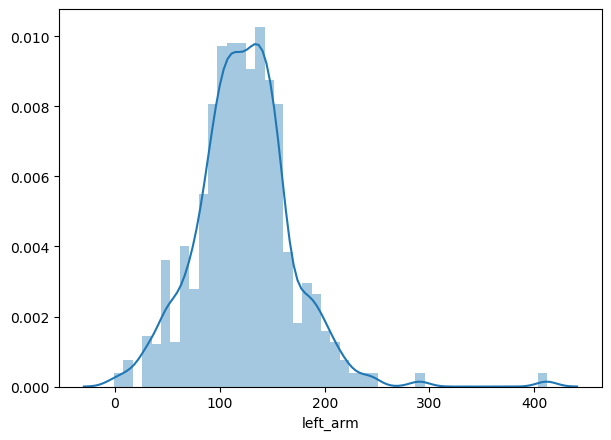

In [566]:
# plot_distribution(patient_data['left_arm'])
sns.distplot(patient_data['left_arm']);

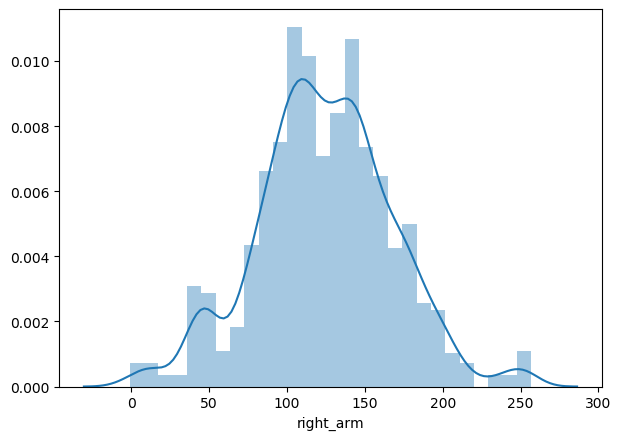

In [567]:
sns.distplot(patient_data['right_arm']);

In [568]:
from scipy.stats import ttest_ind, ttest_ind_from_stats

In [569]:
np.random.seed(42)

In [570]:
t, p = ttest_ind(patient_data['left_arm'], patient_data['right_arm'], equal_var=False)

In [571]:
print("ttest_ind:t={}, p={}".format(t,p))

ttest_ind:t=-0.41629016927388884, p=0.6772280568137528


- In order to identify the difference between the length of left arm and right arm we perform the t-test with the following hypothesis testing.
    - Null Hypothesis: Length of left arm and length of right arm are equal.
    - Alternate Hypothesis: Length of left arm and length or right arm are not equal.
- The results of our t-test suggest a p-value of 0.677 which is greater than our significance value of 0.05. Hence, we cannot reject the null hypothesis and say that there are no difference between the length of left arm and right arm.

#### Compare the “left_shin” and “left_shin2” columns – what conclusion can you draw?

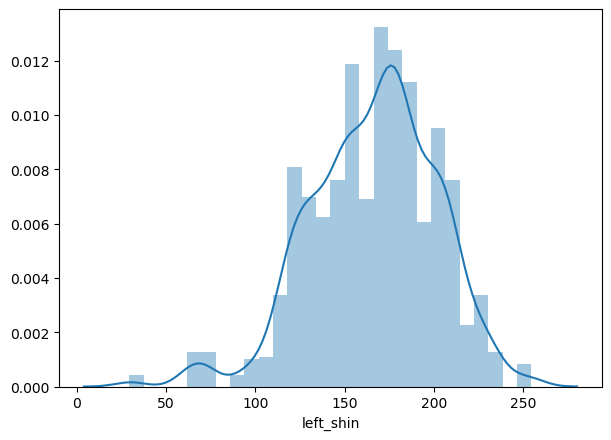

In [572]:
sns.distplot(patient_data['left_shin']);

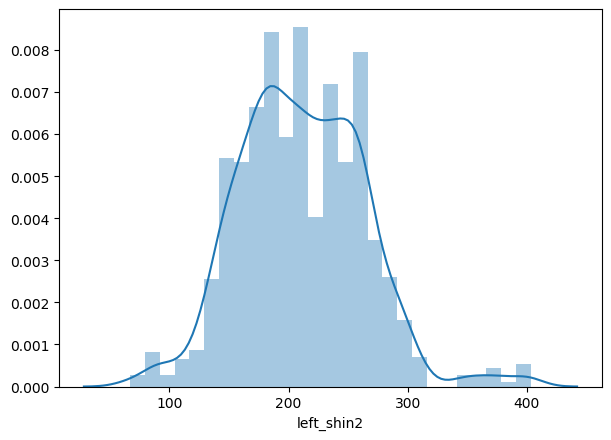

In [573]:
sns.distplot(patient_data['left_shin2']);

In [574]:
t, p = ttest_ind(patient_data['left_shin'], patient_data['left_shin2'], equal_var=False)

In [575]:
print("ttest_ind:t={}, p={}".format(t,p))

ttest_ind:t=-27.287132279835497, p=2.9208083367649206e-144


- We compare the left_shin1 and left_shin2 lengths to see if they are different using a t-test. The hypothesis for this test are:
    - Null Hypothesis: There are no differences between the Length of left_shin1 and length of left_shin2.
    - Alternate Hypothesis: There are differences between the Length of left_shin1 and length of left_shin2.
- The results of our t-test suggest a p-value of 2.92e-144 which is very less than our significance value of 0.05. Hence, we reject the null hypothesis and say that there are differences between the length of left shin1 and left shin2.

#### Train a simple model to predict height using all other variables. Visualise the performance of this model.

In [576]:
X = patient_data.iloc[:,1:]
y = patient_data.iloc[:,0]

In [577]:
# Splitting the dataset to train and test
# random.seed(10)

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=1)

print("Shape of X train set:",X_train.shape)
print("Shape of X test set:",X_test.shape)
print("Shape of y train set:",y_train.shape)
print("Shape of y test set:",y_test.shape)

Shape of X train set: (1180, 12)
Shape of X test set: (295, 12)
Shape of y train set: (1180,)
Shape of y test set: (295,)


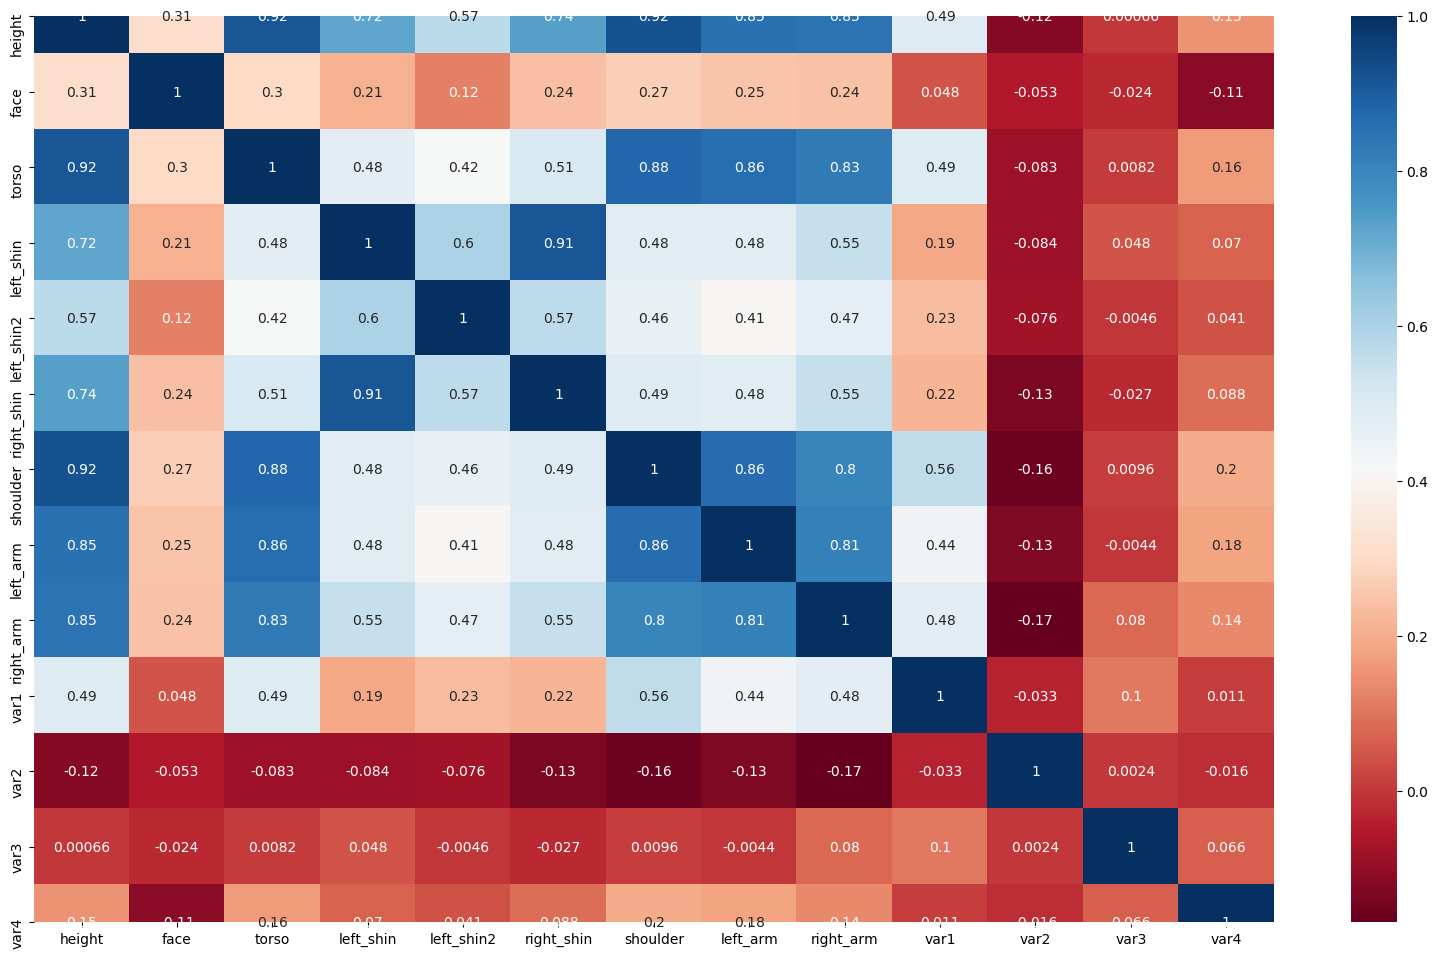

In [578]:
# Checking for multicollinearity

plt.figure(figsize=(20,12))
sns.heatmap(patient_data.corr(),cmap='RdBu',annot=True);

In [579]:
# Scaling the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

ss = MinMaxScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [580]:
#Function for screeplot to plot pca variances. 

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    font = {'weight': 'bold', 'fontsize': 12}
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(0, num_components, 10):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", **font)
        if i:
            ax.annotate(r"%s%%" % ((str(cumvals[i]*100)[:4])), (ind[i]+0.2, cumvals[i]+0.02), va="bottom", ha="center", **font)
    
    ax.annotate(r"%s%%" % ((str(cumvals.max()*100)[:4])), (ind[num_components-1]+0.2, cumvals[num_components-1]+0.02), va="bottom", ha="center", **font)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    ax.set_xlabel("Principal Component", **font)
    ax.set_ylabel("Variance Explained (%)", **font)
    cur_axes = plt.gca()
    cur_axes.spines['right'].set_visible(False)
    cur_axes.spines['top'].set_visible(False)
    plt.title('Explained Variance Per Principal Component', **font)
    plt.xticks(**font)
    plt.yticks(**font)

In [581]:
from sklearn.decomposition import PCA

# Apply PCA to the data. Using 10 components after multiple trials
pca = PCA(n_components=7, random_state=42)
pca = pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

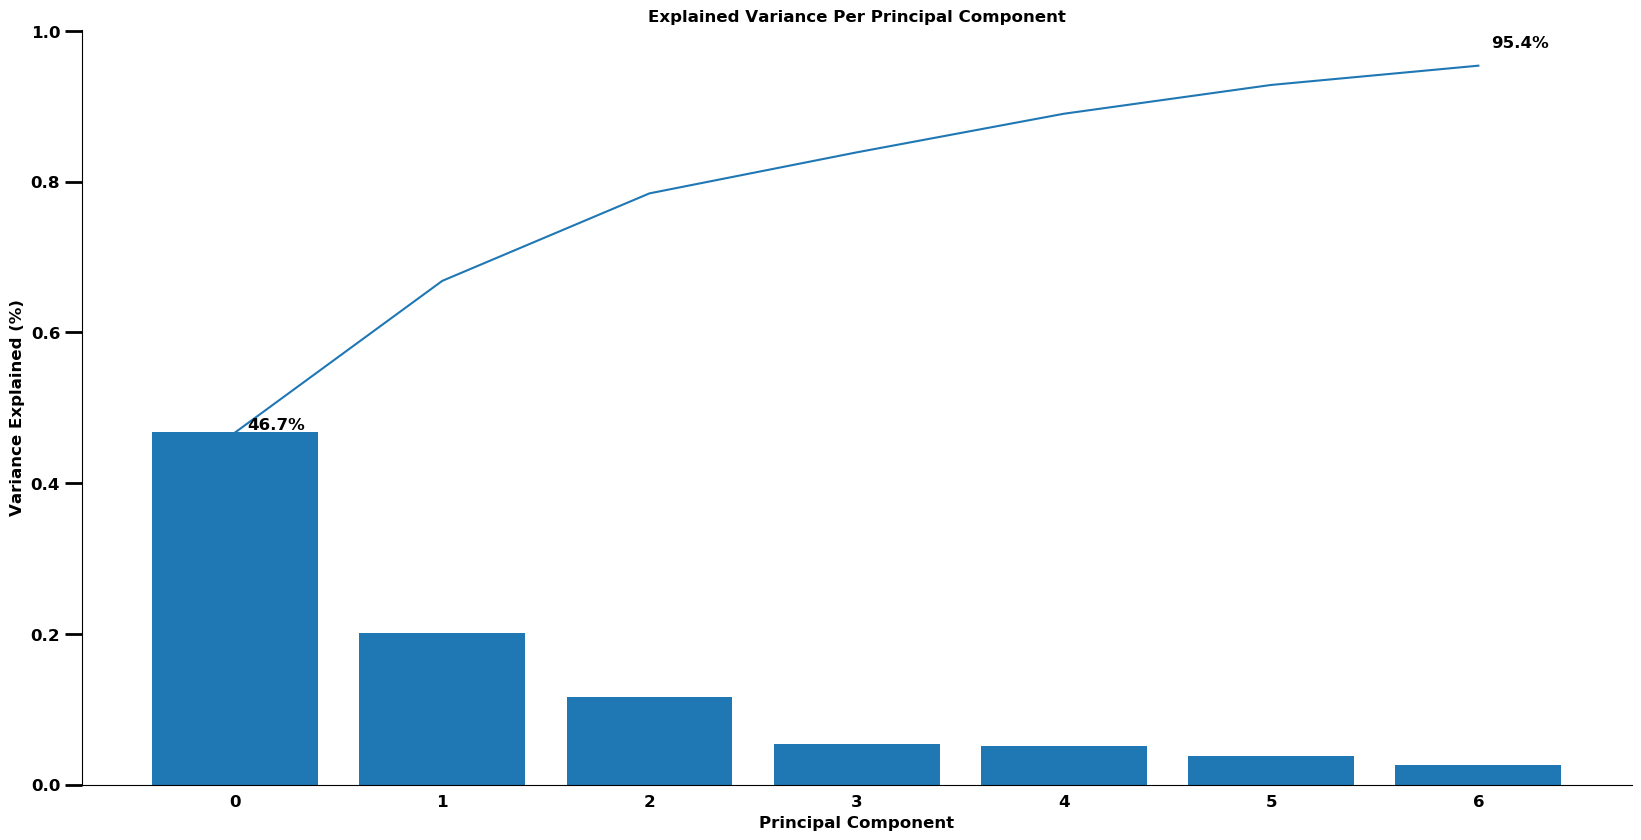

In [582]:
scree_plot(pca)

In [583]:
print('Maximum Explained Variance: {}'.format(round(pca.explained_variance_ratio_.sum()*100, 2)))

Maximum Explained Variance: 95.4


- Using 8 components gives maximum explained variance of 96 percent, proceeding with the implementation of linear regression.

In [584]:
from sklearn import linear_model
from sklearn import metrics

In [585]:
lm = linear_model.LinearRegression()

In [586]:
lm_model = lm.fit(X_train, y_train)

In [587]:
y_train_pred = lm_model.predict(X_train)
y_test_pred = lm_model.predict(X_test)

In [588]:
print('MAE Train:', metrics.mean_absolute_error(y_train, y_train_pred))
print('R2 score Train:',metrics.r2_score(y_train, y_train_pred))
print('RMSE Train:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))

MAE Train: 11.144695607233288
R2 score Train: 0.9911830487731842
RMSE Train: 16.565896055917726


In [589]:
# Calculating the metrics for our model performance
print('MAE Test:', metrics.mean_absolute_error(y_test, y_test_pred))
print('R2 score Test:',metrics.r2_score(y_test, y_test_pred))
print('RMSE Test:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

MAE Test: 10.932518542143358
R2 score Test: 0.9927568259825124
RMSE Test: 15.183904868110156


#### Train a more complex model to predict height. Compare the performance of these two models.

In [463]:
from sklearn.ensemble import RandomForestRegressor

In [464]:
rf = RandomForestRegressor()

In [483]:
rf_model = rf.fit(X_train, y_train)

In [484]:
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

In [485]:
print('MAE Train:', metrics.mean_absolute_error(y_train, y_train_pred))
print('R2 score Train:',metrics.r2_score(y_train, y_train_pred))
print('RMSE Train:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))

MAE Train: 1.4109649957415082
R2 score Train: 0.9997615038148548
RMSE Train: 2.7245603439782577


In [486]:
# Calculating the metrics for our model performance
print('MAE Test:', metrics.mean_absolute_error(y_test, y_test_pred))
print('R2 score Test:',metrics.r2_score(y_test, y_test_pred))
print('RMSE Test:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

MAE Test: 3.4239584918958452
R2 score Test: 0.9987443368914579
RMSE Test: 6.322015872713617


In [488]:
from sklearn.model_selection import GridSearchCV
# # creating a parameter grid for cross validation and hyper parameter tuning

param_grid = {
    'max_depth': [80, 90,100],
    'min_samples_leaf': [3, 4, 5,6],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [50,150,200,500]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)

# # finding the best parameter from our cross validation
grid_search.fit(X_train, y_train)
print("Best parameters are:",grid_search.best_params_)

# # we are creating model out of the best grid generated by the cross validation
best_grid = grid_search.best_estimator_

# # predicting the values using X_test data set
y_pred_test = best_grid.predict(X_test)

# # predicting with the train set
y_pred_train = best_grid.predict(X_train)

# # Calculating the metrics for our model performance
print('MAE Train:', metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE Train:', metrics.mean_squared_error(y_train, y_pred_train))
print('R2 score Train:',metrics.r2_score(y_train, y_pred_train))
print('RMSE Train:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

# # Calculating the metrics for our model performance
print('MAE Test:', metrics.mean_absolute_error(y_test, y_pred_test))
print('MSE Test:', metrics.mean_squared_error(y_test, y_pred_test))
print('R2 score Test:',metrics.r2_score(y_test, y_pred_test))
print('RMSE Test:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters are: {'max_depth': 90, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 500}
MAE Train: 3.5484955880348457
MSE Train: 56.953452653689304
R2 score Train: 0.9981701788986488
RMSE Train: 7.546751132354194
MAE Test: 6.048685766063504
MSE Test: 149.07782111575654
R2 score Test: 0.9953164516534685
RMSE Test: 12.209742876725805
